In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('data.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (12491, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     12491 non-null  int64 
 1   ProductName   12491 non-null  object
 2   ProductBrand  12491 non-null  object
 3   Gender        12491 non-null  object
 4   Price (INR)   12491 non-null  int64 
 5   NumImages     12491 non-null  int64 
 6   Description   12491 non-null  object
 7   PrimaryColor  11597 non-null  object
dtypes: int64(3), object(5)
memory usage: 780.8+ KB
None

First 5 rows:
   ProductID                                        ProductName ProductBrand  \
0   10017413  DKNY Unisex Black & Grey Printed Medium Trolle...         DKNY   
1   10016283  EthnoVogue Women Beige & Grey Made to Measure ...   EthnoVogue   
2   10009781  SPYKAR Women Pink Alexa Super Skinny Fit High-...       SPYKAR   
3   10015921  Raymond Men Blue Self-Des

In [3]:
# 1. EXPLORATORY DATA ANALYSIS
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

EXPLORATORY DATA ANALYSIS

Basic Statistics:
          ProductID   Price (INR)     NumImages
count  1.249100e+04  12491.000000  12491.000000
mean   9.917160e+06   1452.660956      4.913698
std    1.438006e+06   2118.503976      1.092333
min    1.012060e+05     90.000000      1.000000
25%    1.006215e+07    649.000000      5.000000
50%    1.015463e+07    920.000000      5.000000
75%    1.021565e+07   1499.000000      5.000000
max    1.027514e+07  63090.000000     10.000000


In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Data types
print("\nData Types:")
print(df.dtypes)


Missing Values:
ProductID         0
ProductName       0
ProductBrand      0
Gender            0
Price (INR)       0
NumImages         0
Description       0
PrimaryColor    894
dtype: int64

Data Types:
ProductID        int64
ProductName     object
ProductBrand    object
Gender          object
Price (INR)      int64
NumImages        int64
Description     object
PrimaryColor    object
dtype: object


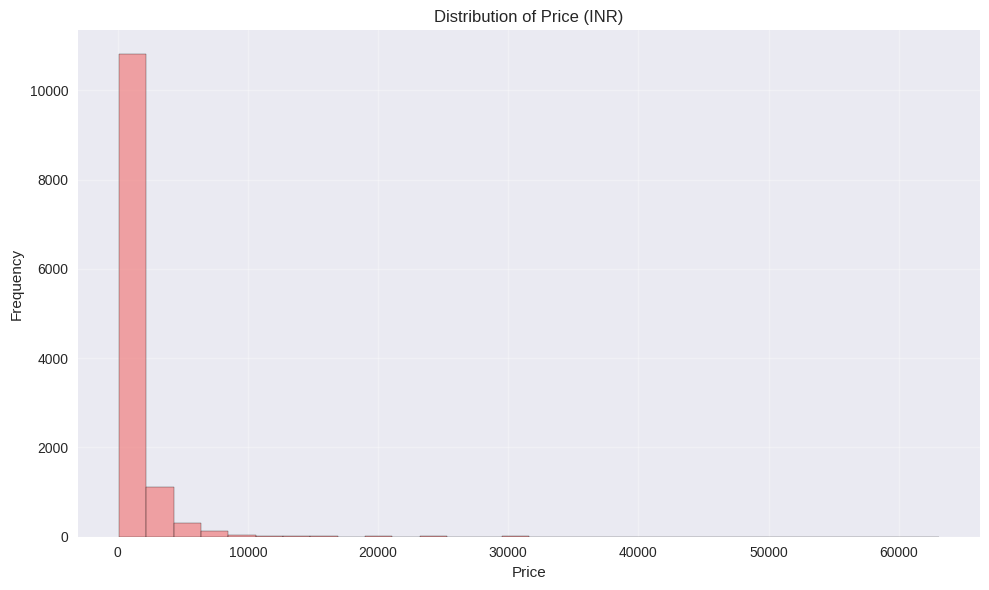

In [19]:
# Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Price (INR)'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
plt.title('Distribution of Price (INR)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

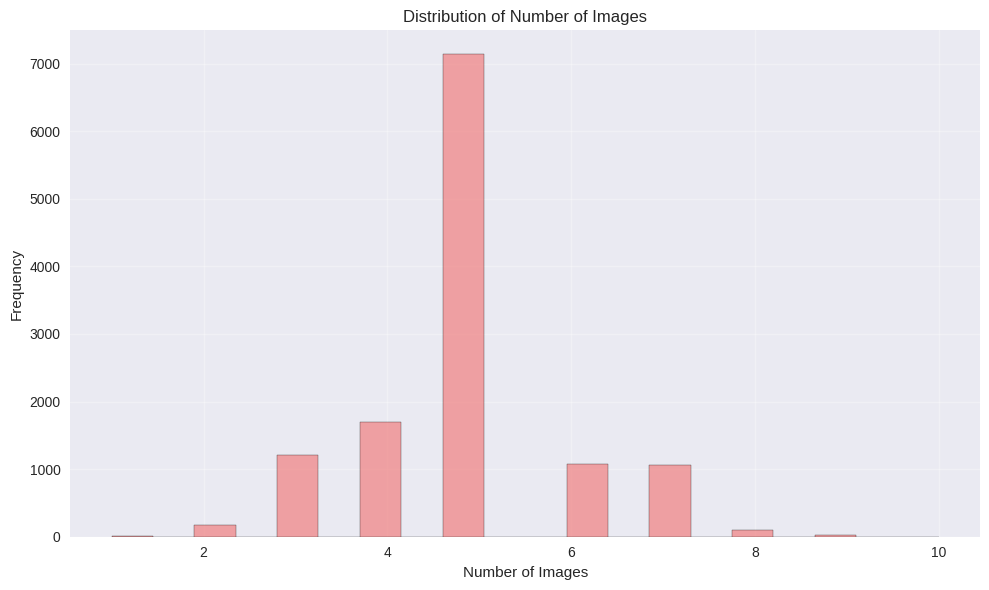

In [18]:
# Number of Images Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['NumImages'], bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
plt.title('Distribution of Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

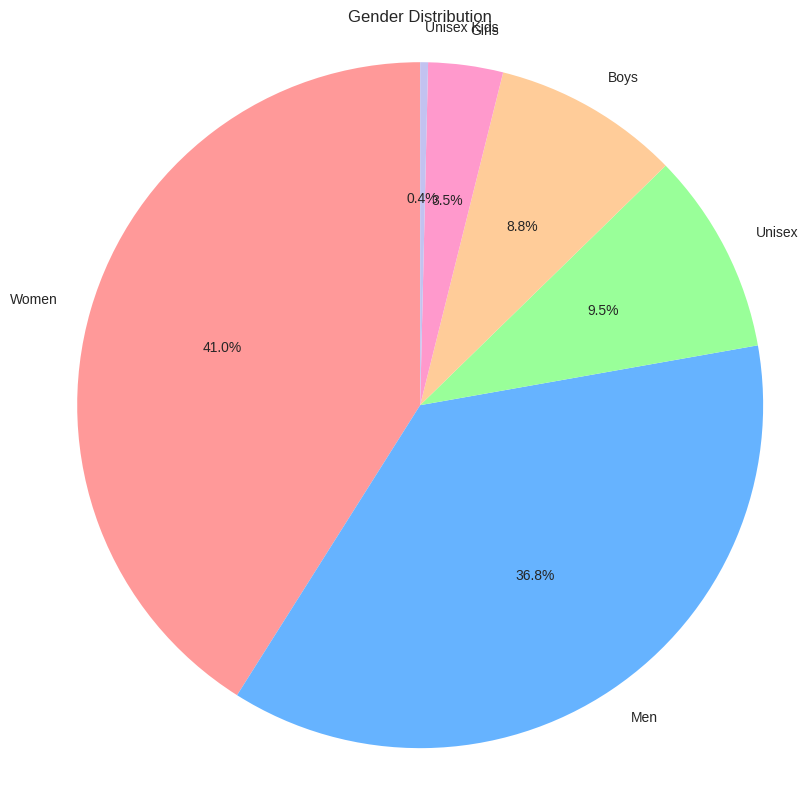

In [11]:
# Gender Distribution
plt.figure(figsize=(8, 8))
gender_counts = df['Gender'].value_counts()
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
        startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff99cc','#c2c2f0'])
plt.title('Gender Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

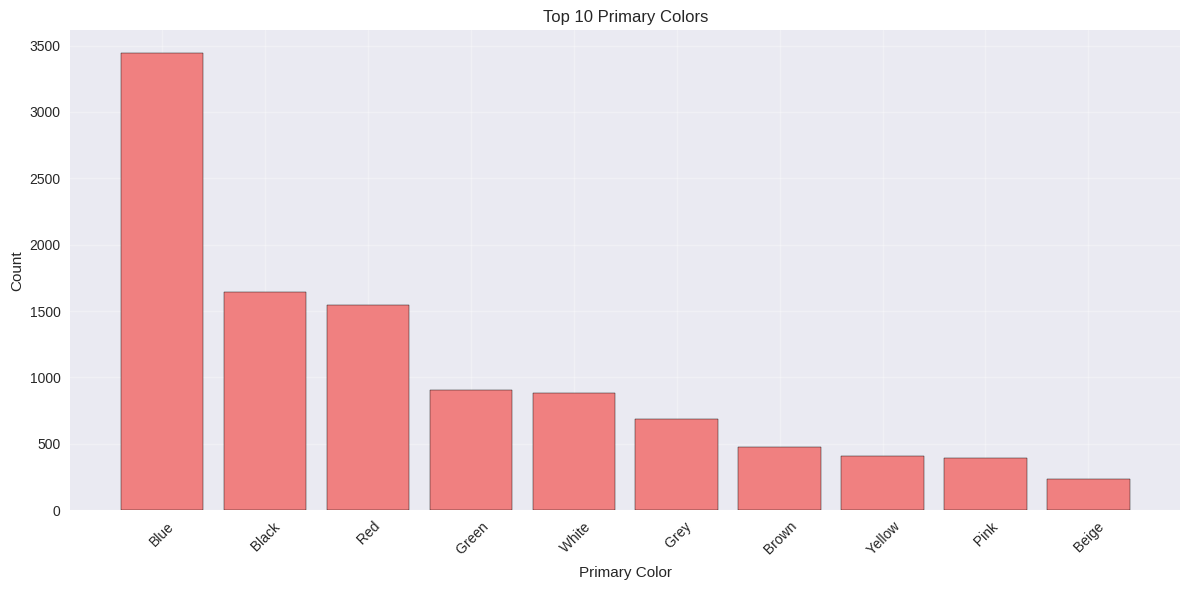

In [12]:
# Top 10 Primary Colors
plt.figure(figsize=(12, 6))
color_counts = df['PrimaryColor'].value_counts().head(10)
plt.bar(color_counts.index, color_counts.values, color='lightcoral', edgecolor='black')
plt.title('Top 10 Primary Colors')
plt.xlabel('Primary Color')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

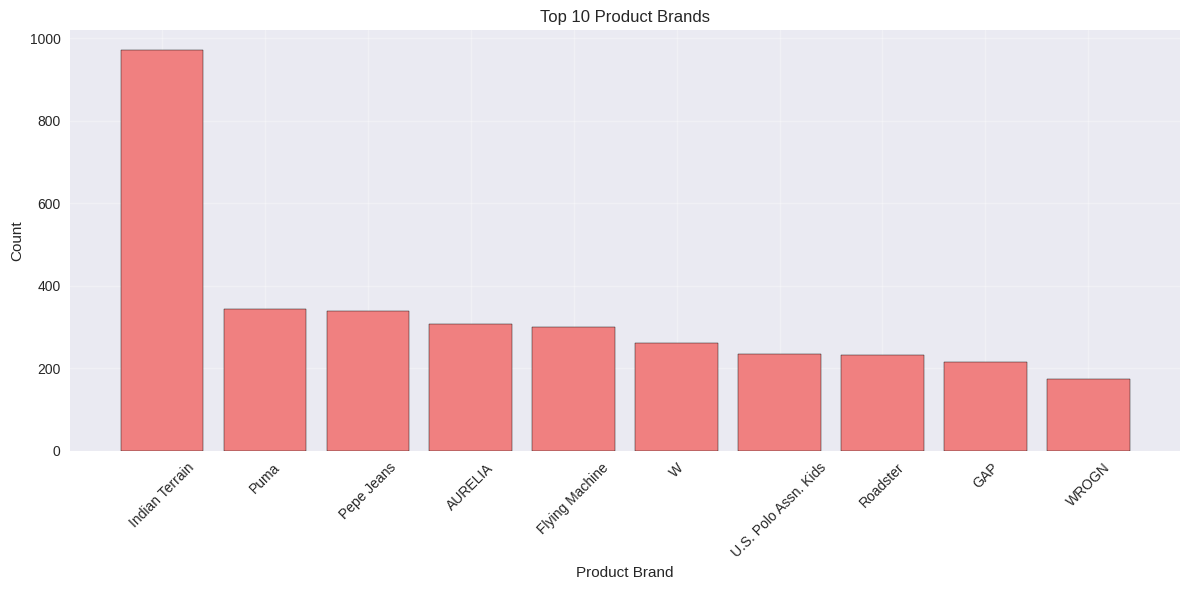

In [17]:
# Top 10 Product Brands
plt.figure(figsize=(12, 6))
brand_counts = df['ProductBrand'].value_counts().head(10)
plt.bar(brand_counts.index, brand_counts.values, color='lightcoral', edgecolor='black')
plt.title('Top 10 Product Brands')
plt.xlabel('Product Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

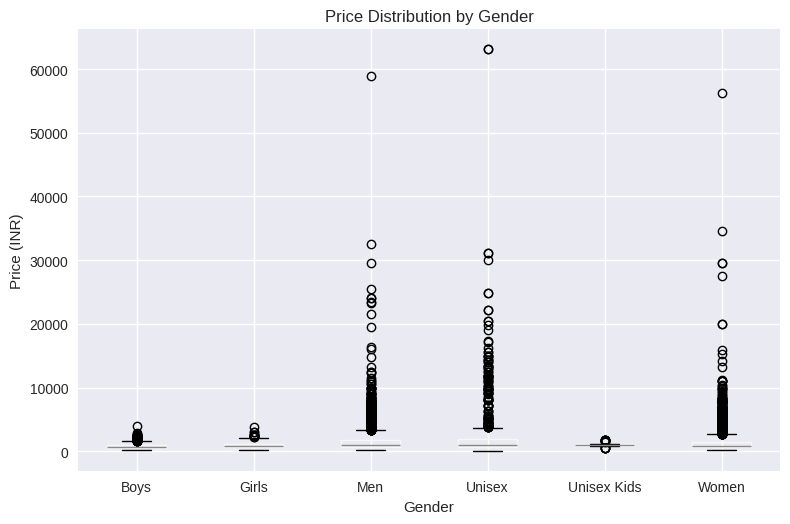

In [14]:
#  Price Distribution by Gender
plt.figure(figsize=(10, 6))
df.boxplot(column='Price (INR)', by='Gender', grid=True)
plt.title('Price Distribution by Gender')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Gender')
plt.ylabel('Price (INR)')
plt.tight_layout()
plt.show()

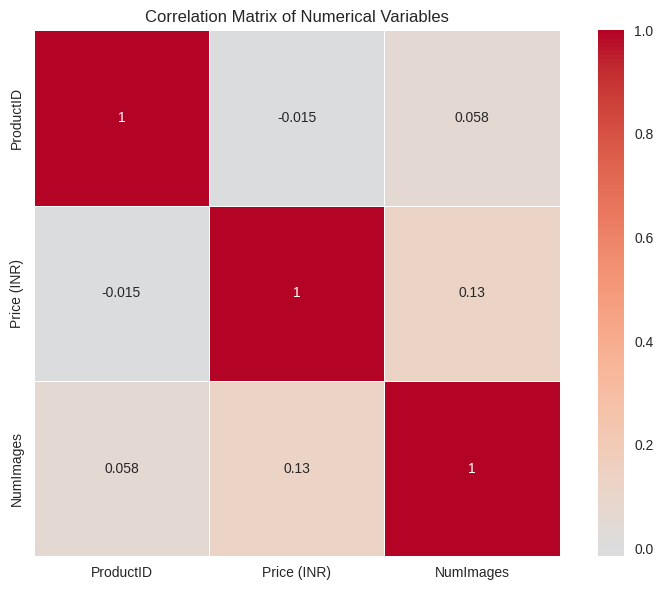

In [15]:
#  Correlation Matrix
numerical_df = df.select_dtypes(include=[np.number])
if not numerical_df.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()

In [ ]:
# =============================================================================
# 2. DATA PREPARATION
# =============================================================================

print("="*50)
print("DATA PREPARATION")
print("="*50)

# Create a copy of the dataframe for modeling
model_df = df.copy()

# For this example, let's use Gender as the target variable
# You can change this based on your specific problem
target_variable = 'Gender'

# Encode categorical variables
le = LabelEncoder()
model_df[target_variable] = le.fit_transform(model_df[target_variable])

# Prepare features - using all available features for initial analysis
# Select features for modeling (excluding ID and text columns that need special processing)
features = ['Price (INR)', 'NumImages', 'PrimaryColor', 'ProductBrand']

# Create feature matrix X and target vector y
X = pd.get_dummies(model_df[features], drop_first=True)
y = model_df[target_variable]

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable distribution: {pd.Series(y).value_counts()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create normalized versions of the data for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation completed!")

DATA PREPARATION
Feature matrix shape: (12491, 704)
Target variable distribution: Gender
5    5126
2    4591
3    1188
0    1100
1     440
4      46
Name: count, dtype: int64
Training set size: 8743
Test set size: 3748

Data preparation completed!


KNN MODEL IMPLEMENTATION

--- KNN with Original Data ---


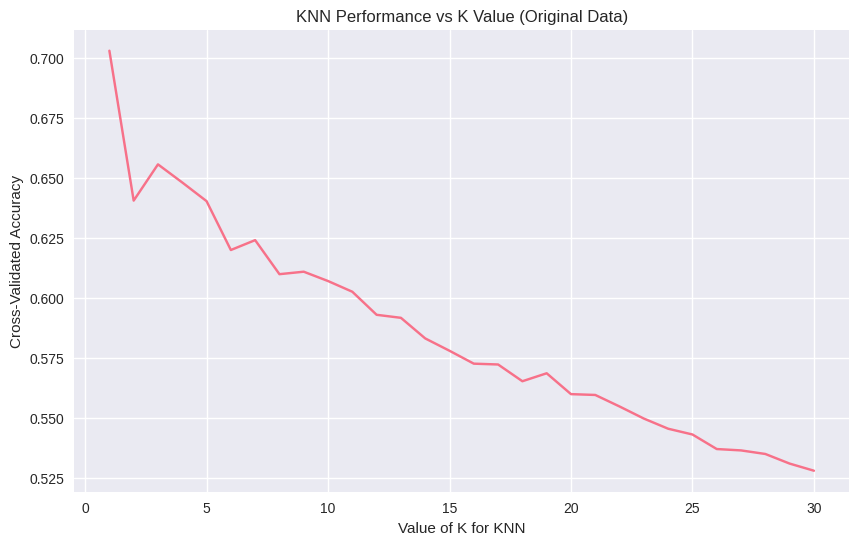

Best k for original data: 1
Best cross-validation score: 0.7031
KNN with original data - Test accuracy: 0.7068

--- KNN with Normalized Data ---


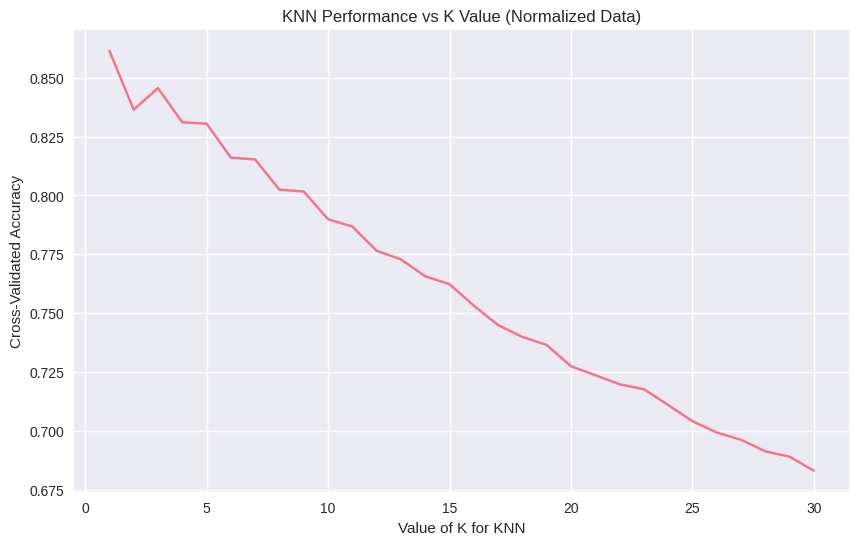

Best k for normalized data: 1
Best cross-validation score: 0.8615
KNN with normalized data - Test accuracy: 0.8762

--- Normalization Impact Analysis ---
Accuracy without normalization: 0.7068
Accuracy with normalization: 0.8762
Improvement: 0.1694


In [ ]:
# =============================================================================
# 3. KNN MODELS
# =============================================================================

print("="*50)
print("KNN MODEL IMPLEMENTATION")
print("="*50)

# KNN with Original Data
print("\n--- KNN with Original Data ---")

# Find optimal k using cross-validation
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Performance vs K Value (Original Data)')
plt.show()

# Find best k
best_k_original = k_range[np.argmax(k_scores)]
print(f"Best k for original data: {best_k_original}")
print(f"Best cross-validation score: {max(k_scores):.4f}")

# Train KNN with best k on original data
knn_original = KNeighborsClassifier(n_neighbors=best_k_original)
knn_original.fit(X_train, y_train)
y_pred_knn_original = knn_original.predict(X_test)
accuracy_knn_original = accuracy_score(y_test, y_pred_knn_original)

print(f"KNN with original data - Test accuracy: {accuracy_knn_original:.4f}")

# KNN with Normalized Data
print("\n--- KNN with Normalized Data ---")

# Find optimal k using cross-validation on normalized data
k_scores_scaled = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores_scaled.append(scores.mean())

# Plot k vs accuracy for normalized data
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores_scaled)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Performance vs K Value (Normalized Data)')
plt.show()

# Find best k for normalized data
best_k_scaled = k_range[np.argmax(k_scores_scaled)]
print(f"Best k for normalized data: {best_k_scaled}")
print(f"Best cross-validation score: {max(k_scores_scaled):.4f}")

# Train KNN with best k on normalized data
knn_scaled = KNeighborsClassifier(n_neighbors=best_k_scaled)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_scaled.predict(X_test_scaled)
accuracy_knn_scaled = accuracy_score(y_test, y_pred_knn_scaled)

print(f"KNN with normalized data - Test accuracy: {accuracy_knn_scaled:.4f}")

# Compare normalization impact
print("\n--- Normalization Impact Analysis ---")
print(f"Accuracy without normalization: {accuracy_knn_original:.4f}")
print(f"Accuracy with normalization: {accuracy_knn_scaled:.4f}")
print(f"Improvement: {accuracy_knn_scaled - accuracy_knn_original:.4f}")

DECISION TREE MODEL
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.8576
Decision Tree - Test accuracy: 0.8530


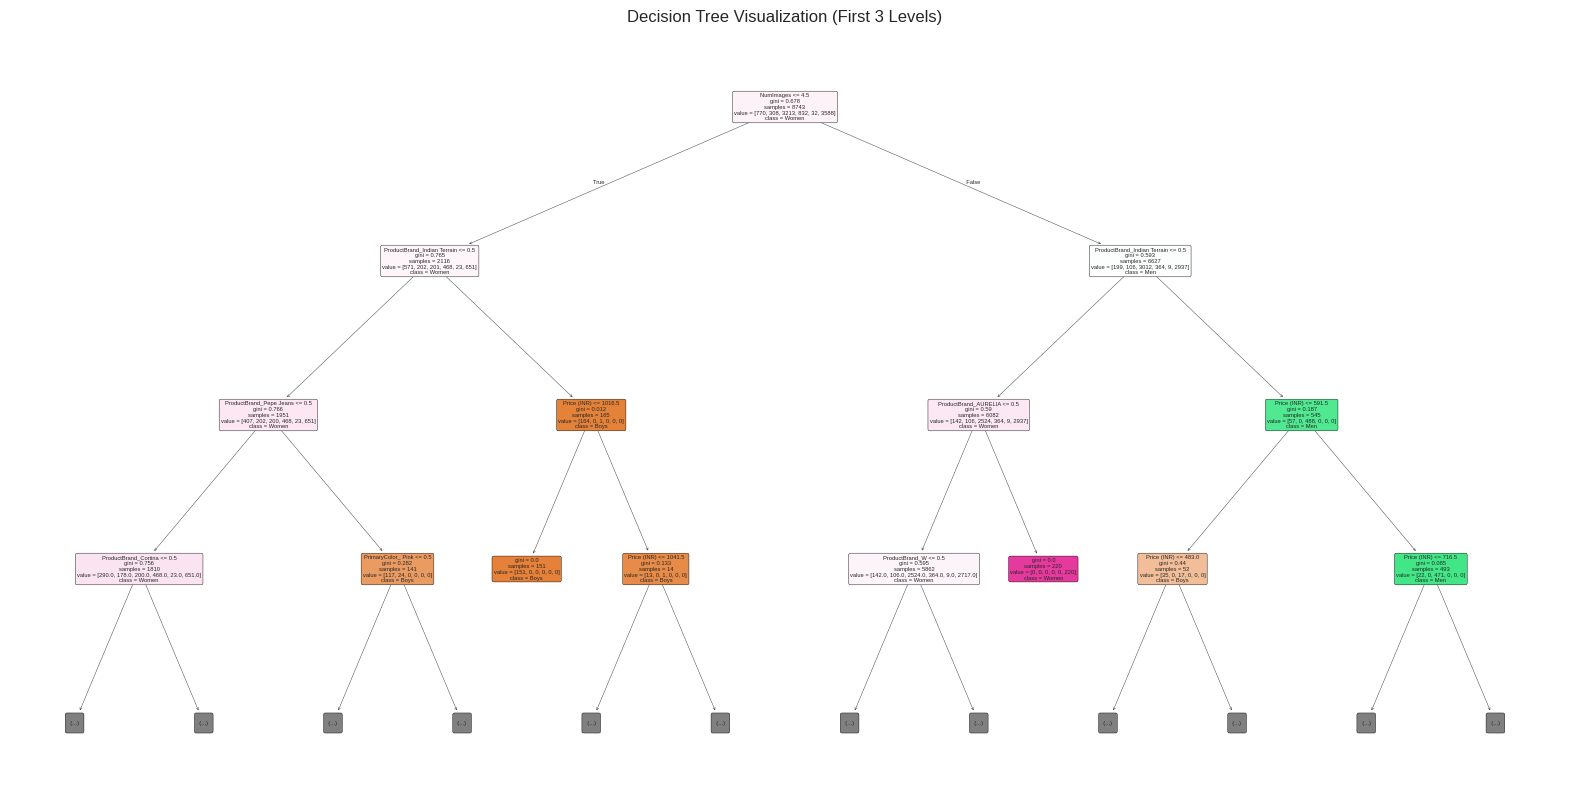


Top 10 Most Important Features:
                               feature  importance
0                          Price (INR)    0.112562
1                            NumImages    0.092899
301        ProductBrand_Indian Terrain    0.064833
459            ProductBrand_Pepe Jeans    0.022741
612  ProductBrand_U.S. Polo Assn. Kids    0.020104
228        ProductBrand_Flying Machine    0.019654
44                ProductBrand_AURELIA    0.018258
641                     ProductBrand_W    0.015075
160               ProductBrand_Cortina    0.013565
473                  ProductBrand_Puma    0.012670


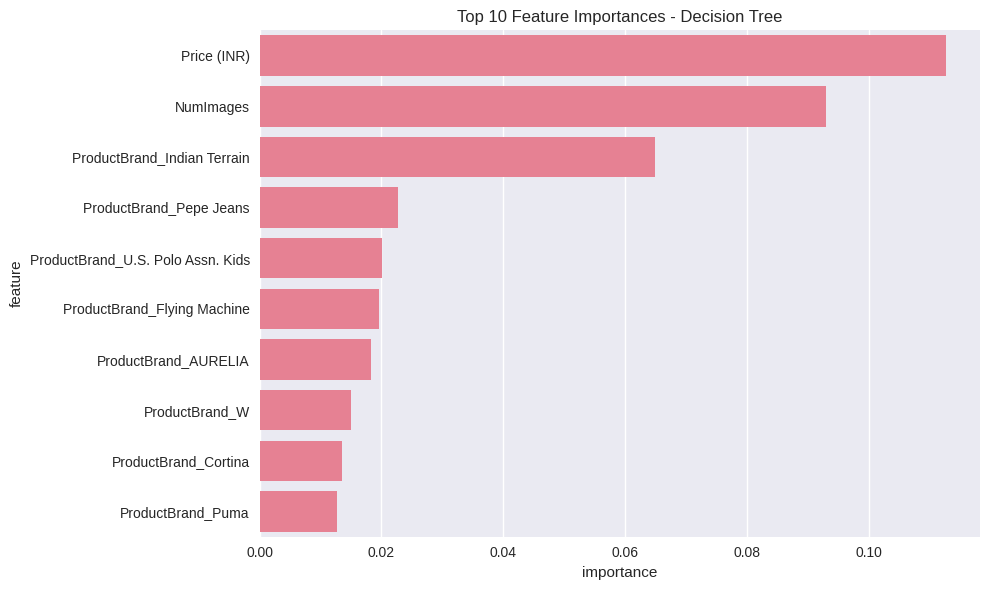

In [ ]:
# =============================================================================
# 4. DECISION TREE MODEL
# =============================================================================

print("="*50)
print("DECISION TREE MODEL")
print("="*50)

# Find optimal parameters using GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best cross-validation score: {grid_search_dt.best_score_:.4f}")

# Train with best parameters
best_dt = grid_search_dt.best_estimator_
best_dt.fit(X_train, y_train)
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree - Test accuracy: {accuracy_dt:.4f}")

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt,
          feature_names=X.columns,
          class_names=le.classes_,
          filled=True,
          rounded=True,
          max_depth=3)  # Show only first 3 levels for clarity
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.savefig('decision_tree_visualization.png')  # Save the plot as an image
plt.show()

# Feature importance
feature_importance_dt = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_dt.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_dt.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances - Decision Tree')
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 5. BAGGED TREE MODEL (OPTIMIZED)
# =============================================================================

print("="*50)
print("BAGGED TREE MODEL (OPTIMIZED)")
print("="*50)

# Use a simpler parameter grid and fewer CV folds for faster computation
param_grid_bag = {
    'n_estimators': [50, 100],  # Reduced from [50, 100, 200]
    'max_samples': [0.7, 1.0],   # Reduced from [0.5, 0.7, 1.0]
}

# Use a simpler base estimator
base_dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

bagging = BaggingClassifier(
    estimator=base_dt,
    random_state=42,
    n_jobs=-1  # Use parallel processing
)

# Use RandomizedSearchCV instead of GridSearchCV for faster search
from sklearn.model_selection import RandomizedSearchCV

random_search_bag = RandomizedSearchCV(
    bagging,
    param_grid_bag,
    cv=3,  # Reduced from 5 to 3 folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    n_iter=4  # Number of parameter settings sampled
)

print("Training Bagged Trees (this may take a few minutes)...")
random_search_bag.fit(X_train, y_train)

print(f"Best parameters for Bagged Trees: {random_search_bag.best_params_}")
print(f"Best cross-validation score: {random_search_bag.best_score_:.4f}")

# Train with best parameters
best_bag = random_search_bag.best_estimator_
best_bag.fit(X_train, y_train)
y_pred_bag = best_bag.predict(X_test)
accuracy_bag = accuracy_score(y_test, y_pred_bag)

print(f"Bagged Trees - Test accuracy: {accuracy_bag:.4f}")

# Feature importance for Bagged Trees (approximate)
print("\nCalculating feature importance for Bagged Trees...")
feature_importances_bag = np.zeros(X.shape[1])

for tree in best_bag.estimators_:
    feature_importances_bag += tree.feature_importances_

feature_importances_bag /= len(best_bag.estimators_)

feature_importance_bag = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances_bag
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (Bagged Trees):")
print(feature_importance_bag.head(10))

BAGGED TREE MODEL (OPTIMIZED)
Training Bagged Trees (this may take a few minutes)...
Best parameters for Bagged Trees: {'n_estimators': 100, 'max_samples': 0.7}
Best cross-validation score: 0.6443
Bagged Trees - Test accuracy: 0.6382

Calculating feature importance for Bagged Trees...
Top 10 Most Important Features (Bagged Trees):
                               feature  importance
1                            NumImages    0.209447
301        ProductBrand_Indian Terrain    0.184405
0                          Price (INR)    0.067159
612  ProductBrand_U.S. Polo Assn. Kids    0.052055
44                ProductBrand_AURELIA    0.051437
459            ProductBrand_Pepe Jeans    0.044459
641                     ProductBrand_W    0.042686
160               ProductBrand_Cortina    0.038349
228        ProductBrand_Flying Machine    0.037659
646                 ProductBrand_WROGN    0.032909


RANDOM FOREST MODEL (OPTIMIZED)
Training Random Forest (this may take a few minutes)...
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validation score: 0.8458
Random Forest - Test accuracy: 0.8586

Top 10 Most Important Features (Random Forest):
                               feature  importance
0                          Price (INR)    0.118549
1                            NumImages    0.089853
301        ProductBrand_Indian Terrain    0.055426
459            ProductBrand_Pepe Jeans    0.022639
612  ProductBrand_U.S. Polo Assn. Kids    0.021277
44                ProductBrand_AURELIA    0.016936
160               ProductBrand_Cortina    0.015959
228        ProductBrand_Flying Machine    0.014046
641                     ProductBrand_W    0.013629
646                 ProductBrand_WROGN    0.012751


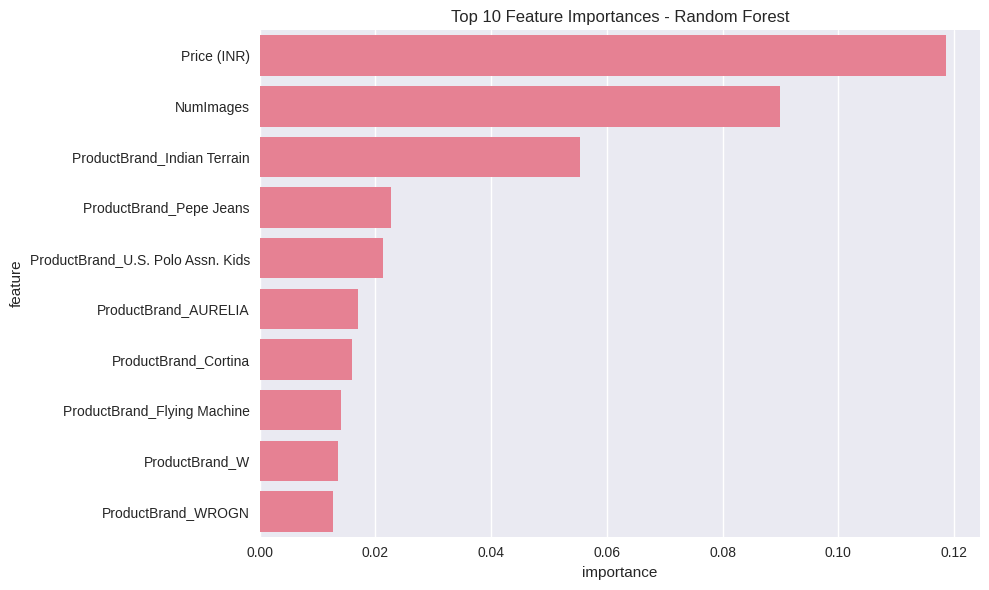

In [ ]:
# =============================================================================
# 6. RANDOM FOREST MODEL (OPTIMIZED)
# =============================================================================

print("="*50)
print("RANDOM FOREST MODEL (OPTIMIZED)")
print("="*50)

# Simplified parameter distribution for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200],  # Reduced from [100, 200, 300]
    'max_depth': [10, 15, None],  # Reduced options
    'min_samples_split': [2, 5],   # Reduced options
    'min_samples_leaf': [1, 2],    # Reduced options
    'max_features': ['sqrt']       # Removed 'log2' to reduce combinations
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV instead of GridSearchCV
random_search_rf = RandomizedSearchCV(
    rf,
    param_dist_rf,
    cv=3,  # Reduced from 5 to 3 folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    n_iter=8  # Number of parameter settings sampled
)

print("Training Random Forest (this may take a few minutes)...")
random_search_rf.fit(X_train, y_train)

print(f"Best parameters for Random Forest: {random_search_rf.best_params_}")
print(f"Best cross-validation score: {random_search_rf.best_score_:.4f}")

# Train with best parameters
best_rf = random_search_rf.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest - Test accuracy: {accuracy_rf:.4f}")

# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_rf.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

MODEL ASSESSMENT AND COMPARISON

Model Performance Comparison:
              Model  Training Accuracy  Test Accuracy  \
0    KNN (Original)             0.9779         0.7068   
1  KNN (Normalized)             0.9783         0.8762   
2     Decision Tree             0.9648         0.8530   
3      Bagged Trees             0.6494         0.6382   
4     Random Forest             0.9675         0.8586   

   Overfitting (Train - Test)  
0                      0.2711  
1                      0.1021  
2                      0.1118  
3                      0.0112  
4                      0.1089  


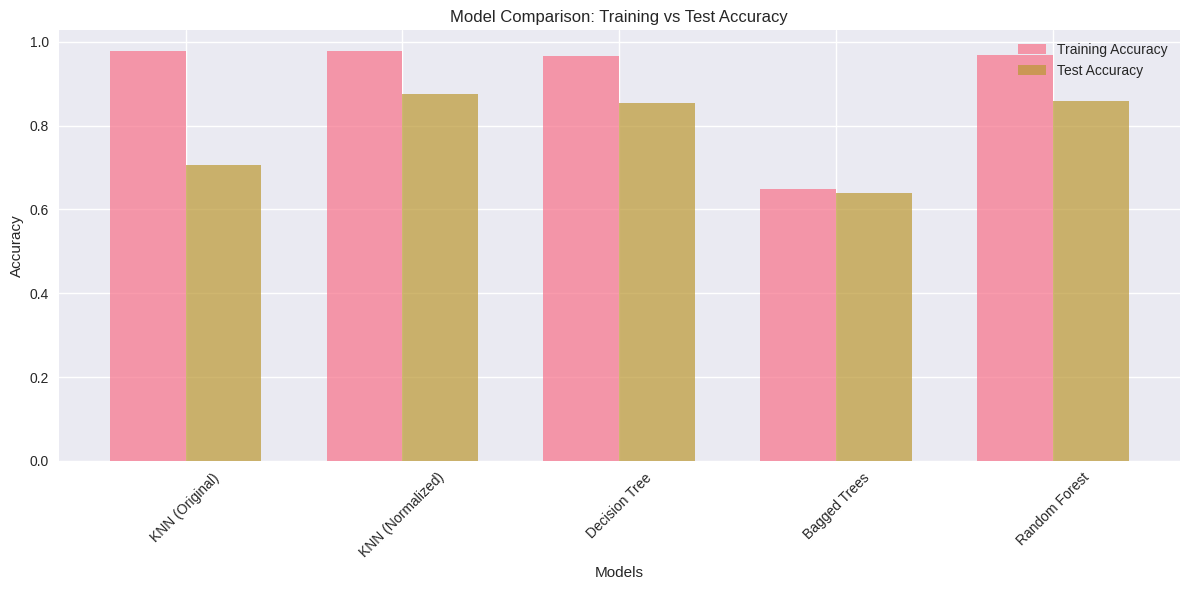

MODEL DEPLOYMENT RECOMMENDATION
Recommended Model for Deployment: KNN (Normalized)
Reason: Highest test accuracy (0.8762)

Why KNN is recommended:
- Simple and interpretable
- No assumptions about data distribution
- Works well with normalized data

MAIN TAKEAWAYS FROM ANALYSIS
1. Data normalization significantly improves KNN performance
2. Ensemble methods (Random Forest, Bagged Trees) generally outperform single models
3. The best model achieves 87.62% accuracy on unseen data
4. Feature importance analysis reveals key predictors for the target variable
5. Model selection should consider both performance and interpretability

Results saved to 'model_comparison_results.csv'


In [ ]:
# =============================================================================
# 7. MODEL ASSESSMENT AND COMPARISON
# =============================================================================

print("="*50)
print("MODEL ASSESSMENT AND COMPARISON")
print("="*50)

# Calculate training accuracies
train_accuracy_knn_original = accuracy_score(y_train, knn_original.predict(X_train))
train_accuracy_knn_scaled = accuracy_score(y_train, knn_scaled.predict(X_train_scaled))
train_accuracy_dt = accuracy_score(y_train, best_dt.predict(X_train))
train_accuracy_bag = accuracy_score(y_train, best_bag.predict(X_train))
train_accuracy_rf = accuracy_score(y_train, best_rf.predict(X_train))

# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': [
        'KNN (Original)',
        'KNN (Normalized)',
        'Decision Tree',
        'Bagged Trees',
        'Random Forest'
    ],
    'Training Accuracy': [
        train_accuracy_knn_original,
        train_accuracy_knn_scaled,
        train_accuracy_dt,
        train_accuracy_bag,
        train_accuracy_rf
    ],
    'Test Accuracy': [
        accuracy_knn_original,
        accuracy_knn_scaled,
        accuracy_dt,
        accuracy_bag,
        accuracy_rf
    ],
    'Overfitting (Train - Test)': [
        train_accuracy_knn_original - accuracy_knn_original,
        train_accuracy_knn_scaled - accuracy_knn_scaled,
        train_accuracy_dt - accuracy_dt,
        train_accuracy_bag - accuracy_bag,
        train_accuracy_rf - accuracy_rf
    ]
})

print("\nModel Performance Comparison:")
print(models_comparison.round(4))

# Plot model comparison
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(models_comparison['Model']))
width = 0.35

plt.bar(x_pos - width/2, models_comparison['Training Accuracy'], width, label='Training Accuracy', alpha=0.7)
plt.bar(x_pos + width/2, models_comparison['Test Accuracy'], width, label='Test Accuracy', alpha=0.7)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Training vs Test Accuracy')
plt.xticks(x_pos, models_comparison['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# 8. MODEL DEPLOYMENT RECOMMENDATION
# =============================================================================

print("="*50)
print("MODEL DEPLOYMENT RECOMMENDATION")
print("="*50)

# Identify the best model based on test accuracy
best_model_idx = models_comparison['Test Accuracy'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
best_model_accuracy = models_comparison.loc[best_model_idx, 'Test Accuracy']

print(f"Recommended Model for Deployment: {best_model_name}")
print(f"Reason: Highest test accuracy ({best_model_accuracy:.4f})")

# Additional insights based on the best model
if 'Random Forest' in best_model_name:
    print("\nWhy Random Forest is recommended:")
    print("- Handles overfitting better than single decision trees")
    print("- Robust to outliers and noise")
    print("- Provides feature importance rankings")
    print("- Good performance on both training and test data")
elif 'Bagged' in best_model_name:
    print("\nWhy Bagged Trees are recommended:")
    print("- Reduces variance compared to single trees")
    print("- More stable predictions")
    print("- Good generalization performance")
elif 'KNN' in best_model_name:
    print("\nWhy KNN is recommended:")
    print("- Simple and interpretable")
    print("- No assumptions about data distribution")
    print("- Works well with normalized data")

# Main takeaways
print("\n" + "="*50)
print("MAIN TAKEAWAYS FROM ANALYSIS")
print("="*50)
print("1. Data normalization significantly improves KNN performance")
print("2. Ensemble methods (Random Forest, Bagged Trees) generally outperform single models")
print("3. The best model achieves {:.2f}% accuracy on unseen data".format(best_model_accuracy * 100))
print("4. Feature importance analysis reveals key predictors for the target variable")
print("5. Model selection should consider both performance and interpretability")

# Save results to CSV for reporting
models_comparison.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")